In [50]:
import numpy as np
import pandas as pd
import os
import random
import h5py
import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from torch.utils.data import DataLoader, TensorDataset

In [36]:
# Extract and prepare data

# Windows directory

garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'


# 7 Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# 8 Outputs
teff = []
luminosity = []
dnufit = []
FeH = []
G_GAIA = []
massfin = []
numax = []
MeH = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    # Not necessary if using all the tracks
    track_names = list(tracks.keys())

    # Tracks that don't have G_GAIA for some reason??
    tracks_to_remove = ['track08278', 'track07930']
    for track in tracks_to_remove:
        if track in track_names:
            track_names.remove(track)  
    
    # Set the number of tracks to process
    selected_tracks = track_names[:]

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        # Inputs
        ages.append(track['age'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

        # Outputs
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        dnufit.append(track['dnufit'][:])
        FeH.append(track['FeH'][:])
        G_GAIA.append(track['G_GAIA'][:])
        massfin.append(track['massfin'][:])
        numax.append(track['numax'][:])
        MeH.append(track['MeH'][:])

# Convert lists to numpy arrays and concatenate 
# Define a small constant to avoid log10(0)
epsilon = 1e-10

# Features requiring log10 transformation
log10_vars_inputs = [ages, massini, alphamlt, eta, yini]

# Transform log10 variables
log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]

# Concatenate all inputs, including raw `fehini` and `yini`
inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), 
                                               np.concatenate(alphafe).reshape(-1, 1)])

# Features requiring log10 transformation (strictly positive outputs)
log10_vars_outputs = [teff, luminosity, dnufit, massfin, numax]

# Transform log10 variables
log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]

# Combine transformed log10 outputs with raw FeH and MeH
# FeH and MeH are not transformed, concatenated directly
outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1), 
                                                 np.concatenate(MeH).reshape(-1, 1),
                                                 np.concatenate(G_GAIA).reshape(-1, 1)])



In [49]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

print(f"Number of test samples: {X_test_tensor.shape[0]}")
print(f"Number of training samples: {X_train_tensor.shape[0]}")
print(f"Number of features: {X_test_tensor.shape[1]}")



Number of test samples: 1496750
Number of training samples: 5986996
Number of features: 7


In [38]:
# Redefine model class and load model

class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  
            nn.ReLU(),
            nn.Linear(256, 256),  # 2
            nn.ReLU(),
            nn.Linear(256, 256),  # 3
            nn.ReLU(),
            nn.Linear(256, 256),  # 4
            nn.ReLU(),
            nn.Linear(256, 256),  # 5
            nn.ReLU(),
            nn.Linear(256, output_dim)  # Output layer
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
ckpt_path = "best_model_v7-epoch=3583-val_loss=0.0042.ckpt"
input_dim = 7  # Number of input features
output_dim = 8  # Number of output features
model = GarstecNet.load_from_checkpoint(ckpt_path, input_dim=input_dim, output_dim=output_dim)
device = torch.device("cpu")
model.to(device)
model.eval()  


GarstecNet(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=8, bias=True)
  )
  (criterion): MSELoss()
)

In [39]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = scaler_y.inverse_transform(predictions.numpy())
    y_test_actual = scaler_y.inverse_transform(y_test_tensor.numpy())

    # Calculate evaluation metrics
    r2 = r2_score(y_test_actual, predictions)
    mae = mean_absolute_error(y_test_actual, predictions)

    print(f'R^2 Score: {r2:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')

R^2 Score: 0.9958
Mean Absolute Error: 0.0187


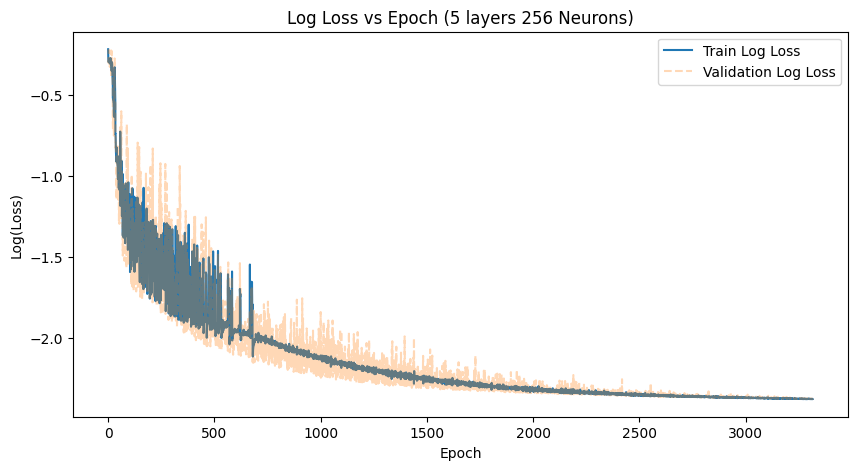

In [51]:
# Log dir for 5 layer 256 neuron training from 0-3300 epochs
log_dir = "version_17399621"

# Load event file
event_file = [f for f in os.listdir(log_dir) if f.startswith("events.out.tfevents")][0]
event_path = os.path.join(log_dir, event_file)
event_acc = EventAccumulator(event_path, size_guidance={'scalars': 0})
event_acc.Reload()

# Extract scalars
train_loss = event_acc.Scalars("train_loss_epoch")  # Per epoch logging
val_loss = event_acc.Scalars("val_loss")  # Validation loss per epoch

# Convert steps to epochs and apply log10 transformation
train_loss_df = pd.DataFrame([[s.step // 50, np.log10(s.value)] for s in train_loss if s.value > 0], columns=["epoch", "log_loss"])
val_loss_df = pd.DataFrame([[s.step // 50, np.log10(s.value)] for s in val_loss if s.value > 0], columns=["epoch", "log_loss"])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df["epoch"], train_loss_df["log_loss"], label="Train Log Loss", linestyle="-")
plt.plot(val_loss_df["epoch"], val_loss_df["log_loss"], label="Validation Log Loss", linestyle="--", alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Log(Loss)")
plt.title("Log Loss vs Epoch (5 layers 256 Neurons)")
plt.legend()
plt.show()


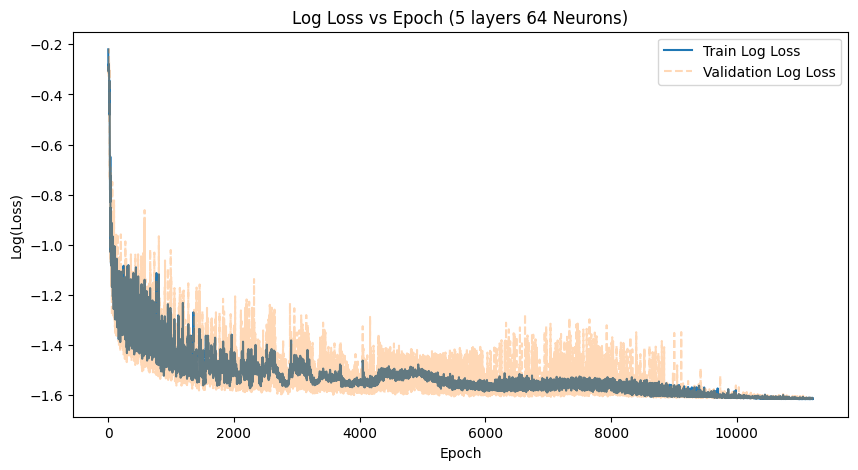

In [41]:
# Log dir for 5 layer 64 neuron training from 0-12500 epochs
log_dir = "version_17465661"

# Load event file
event_file = [f for f in os.listdir(log_dir) if f.startswith("events.out.tfevents")][0]
event_path = os.path.join(log_dir, event_file)
event_acc = EventAccumulator(event_path, size_guidance={'scalars': 0})
event_acc.Reload()

# Extract scalars
train_loss = event_acc.Scalars("train_loss_epoch")  # Per epoch logging
val_loss = event_acc.Scalars("val_loss")  # Validation loss per epoch

# Convert steps to epochs and apply log10 transformation
train_loss_df = pd.DataFrame([[s.step // 50, np.log10(s.value)] for s in train_loss if s.value > 0], columns=["epoch", "log_loss"])
val_loss_df = pd.DataFrame([[s.step // 50, np.log10(s.value)] for s in val_loss if s.value > 0], columns=["epoch", "log_loss"])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df["epoch"], train_loss_df["log_loss"], label="Train Log Loss", linestyle="-")
plt.plot(val_loss_df["epoch"], val_loss_df["log_loss"], label="Validation Log Loss", linestyle="--", alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Log(Loss)")
plt.title("Log Loss vs Epoch (5 layers 64 Neurons)")
plt.legend()
plt.show()


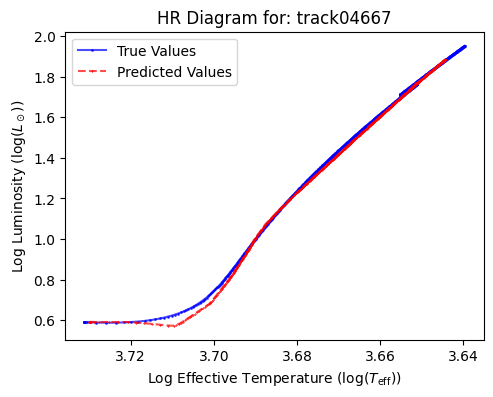

In [ ]:
# Select random track from the same 10000 that we trained the NN on
#specific_track_name = 'trackxxxxx'
specific_track_name = random.choice(track_names)

# Retrieve all required inputs for the specific track
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    ages = specific_track['age'][:].reshape(-1, 1)
    massini = specific_track['massini'][:].reshape(-1, 1)
    fehini = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini = specific_track['yini'][:].reshape(-1, 1)
    eta = specific_track['eta'][:].reshape(-1, 1)
    alphafe = specific_track['alphaFe'][:].reshape(-1, 1)

    # Combine features into a single array
    all_features = np.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

    # Retrieve actual values for plotting
    teff_specific = specific_track['Teff'][:]
    luminosity_specific = specific_track['LPhot'][:]

# Combine inputs and apply log10 transformations where required
epsilon = 1e-10
log10_vars_inputs = [ages, massini, alphamlt, eta, yini]
log10_transformed_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_vars_inputs]

# Combine log-transformed inputs with raw fehini and yini
all_features = np.hstack(log10_transformed_inputs + [fehini, alphafe])

# Scale the input features
all_features_scaled = scaler_X.transform(all_features)

# Convert scaled inputs to PyTorch tensor
all_features_tensor = torch.FloatTensor(all_features_scaled)

# Put the model in evaluation mode and make predictions
model.eval()
with torch.no_grad():
    predictions_specific = model(all_features_tensor).numpy()
    predictions_specific = scaler_y.inverse_transform(predictions_specific)

# Extract predicted Teff and Luminosity
predicted_teff = 10**predictions_specific[:, 0]  # Inverse log10 transformation
predicted_luminosity = 10**predictions_specific[:, 1]

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_predicted_teff = np.log10(predicted_teff)
log_predicted_luminosity = np.log10(predicted_luminosity)


# Plot HR Diagram for the selected track
plt.figure(figsize=(5.4, 4))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_predicted_teff, log_predicted_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()

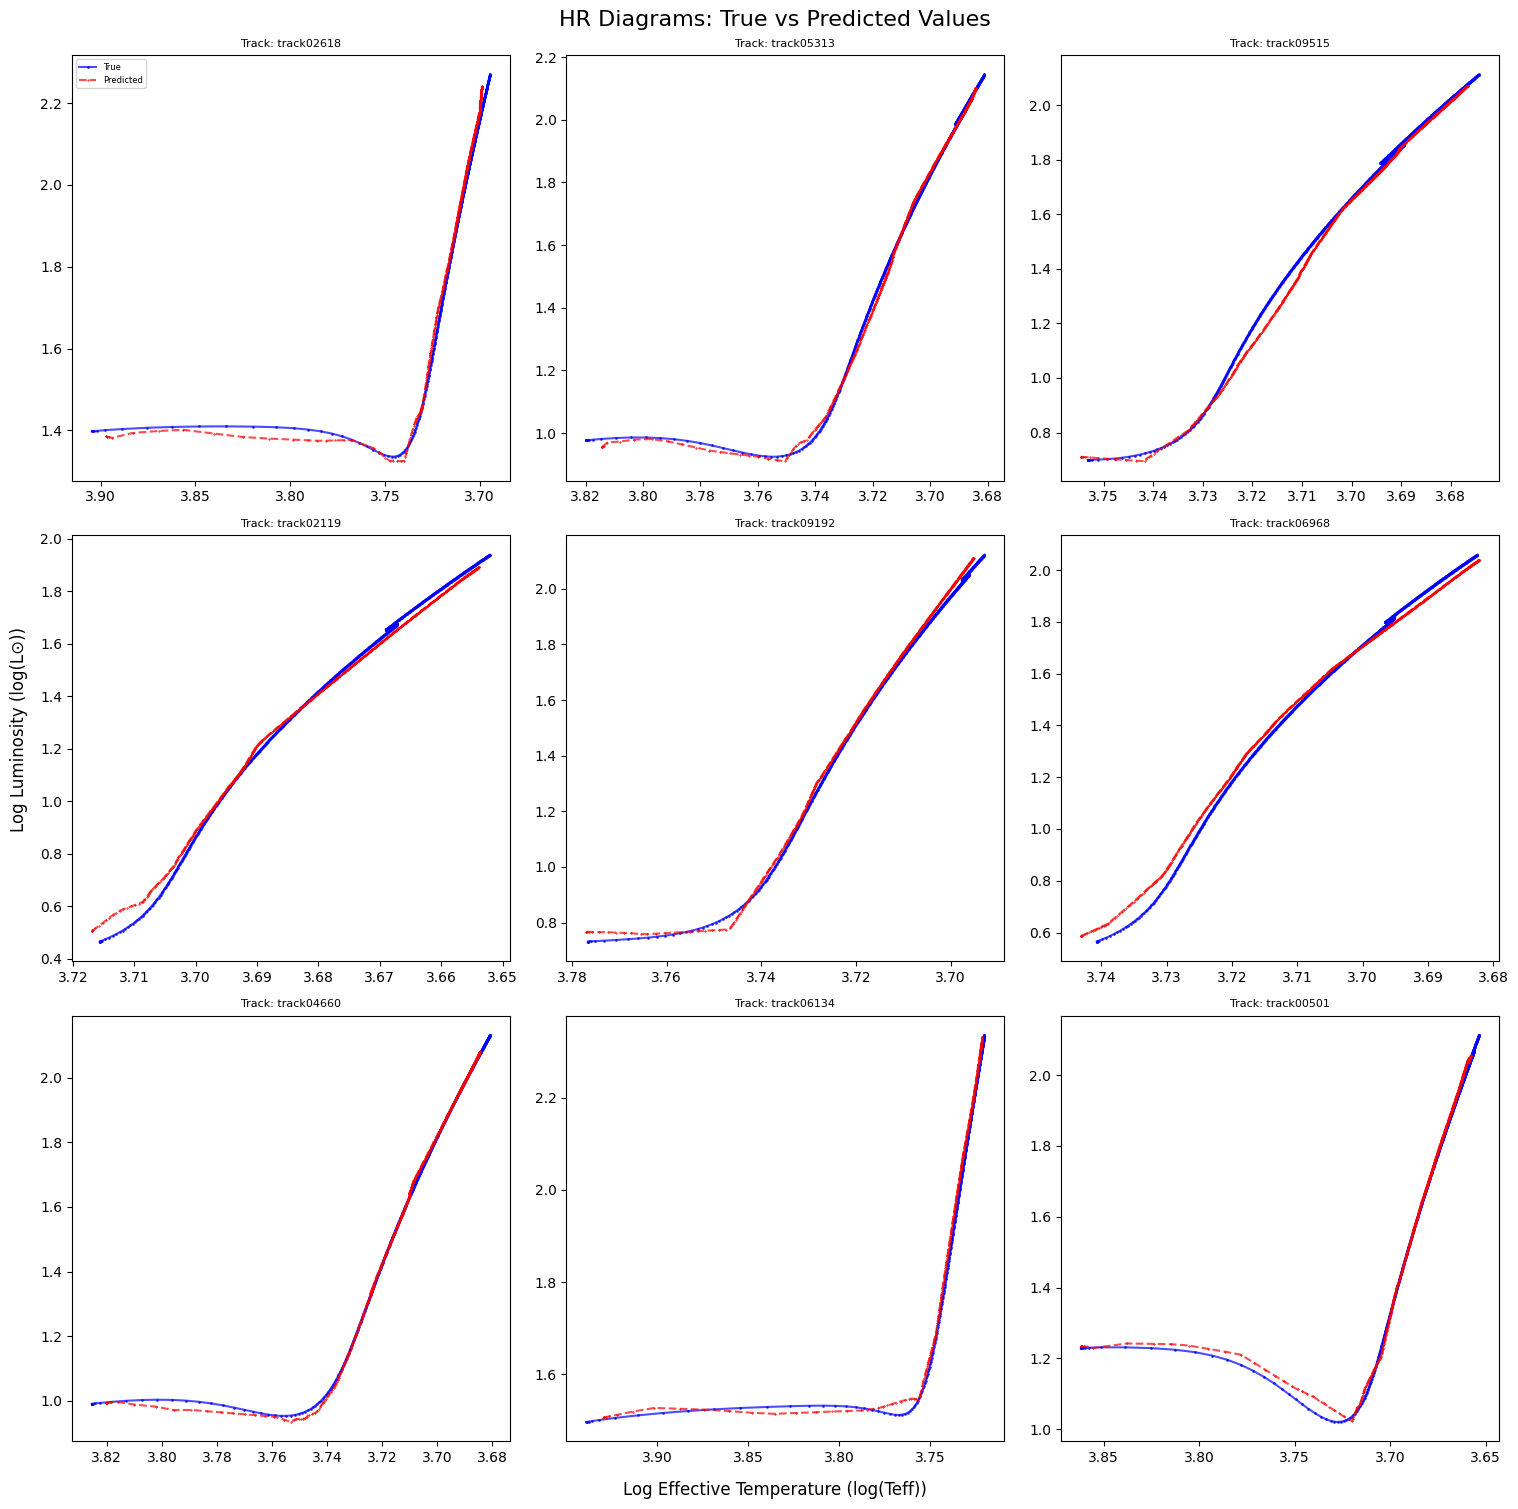

In [43]:
# For plotting multiple predictions

def plot_track_predictions(model, track_name, hdf_file, scaler_X, scaler_y, ax):
    """Plot predictions vs actual values for a single track"""
    with h5py.File(hdf_file, 'r') as hdf:
        specific_track = hdf['grid']['tracks'][track_name]
        
        # Get inputs
        ages = specific_track['age'][:].reshape(-1, 1)
        massini = specific_track['massini'][:].reshape(-1, 1)
        fehini = specific_track['FeHini'][:].reshape(-1, 1)
        alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
        yini = specific_track['yini'][:].reshape(-1, 1)
        eta = specific_track['eta'][:].reshape(-1, 1)
        alphafe = specific_track['alphaFe'][:].reshape(-1, 1)
        
        # Get actual values
        teff_specific = specific_track['Teff'][:]
        luminosity_specific = specific_track['LPhot'][:]

    # Apply log10 transformations to inputs
    epsilon = 1e-10
    log10_vars_inputs = [ages, massini, alphamlt, eta, yini]
    log10_transformed_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_vars_inputs]
    
    # Combine features in same order as training
    all_features = np.hstack(log10_transformed_inputs + [fehini, alphafe])
    
    # Scale features
    all_features_scaled = scaler_X.transform(all_features)
    all_features_tensor = torch.FloatTensor(all_features_scaled)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions_specific = model(all_features_tensor).numpy()
        predictions_specific = scaler_y.inverse_transform(predictions_specific)
    
    # Extract and transform predictions
    predicted_teff = 10**predictions_specific[:, 0]
    predicted_luminosity = 10**predictions_specific[:, 1]
    
    # Log transform for plotting
    log_actual_teff = np.log10(teff_specific)
    log_actual_luminosity = np.log10(luminosity_specific)
    log_predicted_teff = np.log10(predicted_teff)
    log_predicted_luminosity = np.log10(predicted_luminosity)
    
    # Plot
    ax.plot(log_actual_teff, log_actual_luminosity, label='True', color='blue', 
            marker='o', markersize=1, linestyle='-', alpha=0.7)
    ax.plot(log_predicted_teff, log_predicted_luminosity, label='Predicted', 
            color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
    ax.invert_xaxis()
    ax.set_title(f"Track: {track_name}", fontsize=8)
    
    # Only add legend to first subplot
    if ax.get_subplotspec().get_geometry()[2] == 0: 
        ax.legend(fontsize=6)

# Main plotting code
def plot_random_tracks(model, hdf_file, scaler_X, scaler_y, n_tracks=9):
    # Get list of valid tracks
    with h5py.File(hdf_file, 'r') as hdf:
        track_names = list(hdf['grid']['tracks'].keys())
        # Remove problematic tracks
        tracks_to_remove = ['track08278', 'track07930']
        for track in tracks_to_remove:
            if track in track_names:
                track_names.remove(track)
    
    # Randomly select tracks
    selected_tracks = random.sample(track_names, n_tracks)
    
    # Create figure with subplots
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('HR Diagrams: True vs Predicted Values', fontsize=16)
    
    # Add common labels
    fig.text(0.5, -0.01, 'Log Effective Temperature (log(Teff))', ha='center', fontsize=12)
    fig.text(-0.01, 0.5, 'Log Luminosity (log(L⊙))', va='center', rotation='vertical', fontsize=12)
    
    # Plot each track
    for idx, track_name in enumerate(selected_tracks):
        row = idx // 3
        col = idx % 3
        plot_track_predictions(model, track_name, hdf_file, scaler_X, scaler_y, axs[row, col])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  
    plt.show()

plot_random_tracks(model, garstec_data, scaler_X, scaler_y)